# Exploration of the SpaceNet Images and Building a Ground Truth Mask

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline



Let's start by taking a look at one of our images to see what we're working with.

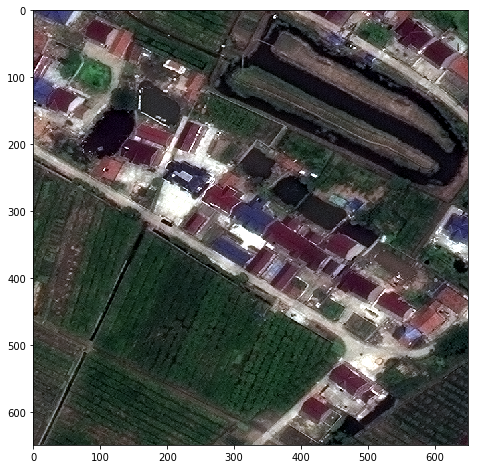

In [32]:
import rasterio

src = rasterio.open('../AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_4_Shanghai_img1911.tif')
img = src.read([5, 3, 2]).transpose([1,2,0])

def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled


# Plot the rescaled image
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scale_bands(img))


Here we can see some beautiful farmland.  At least we know that it exists!  It's a start but we have thousands of images, and I really don't feel like going through them one-by-one to see which ones contain farmland.  So let's harness the power of those who've solved (or at least had the best intentions of solving) that problem for us.

First, let's get some more info on this image.

In [3]:
src.bounds

BoundingBox(left=121.6357992, bottom=31.4207559, right=121.6375542, top=31.4225109)

OK, so this tells us that the bottom-left corner of this image corresponds to latitude/longitude coordinates of (31.4207559, 121.6357992)--or longitude/latitude coordinates of (121.6357992, 31.4207559) if that floats your boat. 

Just as a quick sanity check, let's check an image that borders the one above and make sure it's coordinates are almost identical.

In [4]:
src2 = rasterio.open('../AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-PanSharpen_AOI_4_Shanghai_img1910.tif')
src2.bounds

BoundingBox(left=121.6357992, bottom=31.4190009, right=121.6375542, top=31.4207559)

This tells us that the src2 image is directly south of the one shown above (note the left and right coordinates match exactly), which I can confirm is accurate.

# Storing a Summary of all Shanghai Images
Below we go through the directory with all our Shanghai images and build a GeoPandas dataframe with the image name and a polygon with the longitude/latitude coordinates.

In [5]:
import os

import geopandas as gpd
import shapely.geometry

image_dir_path = '../AOI_4_Shanghai_Train/RGB-PanSharpen'

# Collect a list of all the images with the .tif extension
tiff_images = [os.path.join(image_dir_path, image_name) 
               for image_name in os.listdir(image_dir_path) 
               if image_name.lower().endswith('tif')]

res = []

for image_file_name in tiff_images:
    
    with rasterio.open(image_file_name) as src:
        
        # Convert the image bounding box into a shapely polygon
        bbox = shapely.geometry.box(*src.bounds)
        
    res.append((image_file_name, bbox))

# Convert the results into a GeoDataFrame
image_summary = gpd.GeoDataFrame(res, columns=['image_name', 'geometry'], crs={'init': 'epsg:4326'})

In [6]:
image_summary.head()

,image_name,geometry
0,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.6638792 31.3242309, 121.6638792 ..."
1,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.7095092 31.2926409001, 121.70950..."
2,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.7095092 31.4172459, 121.7095092 ..."
3,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.7340792 31.2241959001, 121.73407..."
4,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.7024892 31.2838659001, 121.70248..."


We can even take advantage of GeoPandas plotting function to see a nice little map of how our Shanghai images fit together.

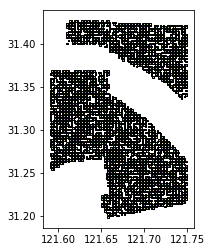

In [7]:
image_summary.plot()

You'll see that there are some holes in the map, as this dataset was part of several competitions and I believe (but don't quote me on this) that the missing images were part of the hold-out set.

We can store this information in a geojson file, which is specially formatted to store geographical information.  We'll use this together with our Open Street Maps data (see below) to match up locations that have been labeled in OSM as being farmland.

In [ ]:
output_file_name = 'vectors/shanghai_RGB_image_summary.geojson'

# Make sure the file doesnt exist (the program will crash if it does)
if os.path.exists(output_file_name):
    os.remove(output_file_name)

# Save the file as a geojson
image_summary.to_file(output_file_name, driver='GeoJSON')

In [8]:
meta_df = gpd.read_file('vectors/shanghai_RGB_image_summary.geojson')
poly = shapely.geometry.box(*meta_df.unary_union.bounds)

In [9]:
import geopandas_osm.osm
landuse_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='landuse')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [10]:
landuse = landuse_df[~landuse_df.landuse.isnull()][['landuse', 'name', 'geometry']]

In [ ]:
landuse.to_file('vectors/shangai_landuse_RGB.geojson', 'GeoJSON');

In [11]:
from collections import Counter
Counter(landuse.landuse.values)

Counter({'basin': 1,
         'commercial': 25,
         'construction': 3,
         'farmland': 18,
         'farmyard': 223,
         'forest': 17,
         'grass': 9,
         'greenfield': 1,
         'greenhouse_horticulture': 2,
         'industrial': 38,
         'meadow': 8,
         'railway': 1,
         'recreation_ground': 1,
         'religious': 1,
         'residential': 82,
         'retail': 12})

This tells us there are 18 polygons that intersect with our images that represent farmland.  This number may not seem very encoraging, but most of these polygons map to a large number of our images.  We can infer this from the map below and the image summary map above.

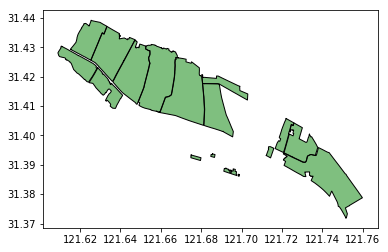

In [14]:
fig, ax = plt.subplots()
landuse.set_geometry(landuse.geometry.apply(shapely.geometry.Polygon), inplace=True)
landuse[landuse.landuse == 'farmland'].plot(color='g', ax=ax)

Now our goal is to find the images that contain farmland by intersecting our images with the OSM data.

In [17]:
farmland = landuse[landuse.landuse == 'farmland'].unary_union

images_containing_farmland = image_summary[image_summary.intersects(farmland)]
images_containing_farmland.head()


,image_name,geometry
8,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.6322892 31.4207559, 121.6322892 ..."
18,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.7200392 31.3926759, 121.7200392 ..."
46,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.6568592 31.4260209, 121.6568592 ..."
49,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.7446092 31.3891659, 121.7446092 ..."
82,../AOI_4_Shanghai_Train/RGB-PanSharpen/RGB-Pan...,"POLYGON ((121.6410642 31.4119809, 121.6410642 ..."


In [19]:
images_containing_farmland.size

764

OK so we have 764 images with at least some farmland in them.  We can work with this.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


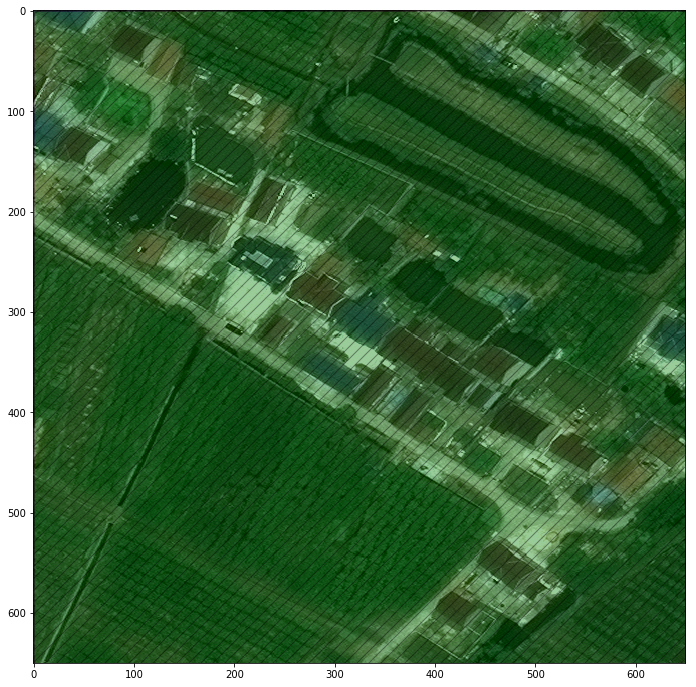

In [33]:
from descartes import PolygonPatch

# # Calculate the proportion of each image taken up by forest
# proportion_forest = images_containing_forest.intersection(all_forest).area / images_containing_forest.area

# # Find the images with between 20% and 80% forest
# has_some_forest = np.logical_and(0.2 < proportion_forest, proportion_forest < 0.8)
# images_containing_some_forest = images_containing_forest[has_some_forest]

# # Pick the first image on the list
# file_name = images_containing_some_forest.image_name.values[0]

# # Load the image
# with rasterio.open(file_name) as src:
#         img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        #print(src.read()[[5, 3, 2, 0, 1, 4, 6, 7], :, :])
img_bounds = shapely.geometry.box(*src.bounds)
img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
        
# Get the intersection between the forest and the image bounds
image_farmland_area = farmland.intersection(img_bounds)

# Transform it into pixel coordinates
image_farmland_area_pxcoords = shapely.affinity.affine_transform(image_farmland_area, img_transform)

fig, ax = plt.subplots(figsize=(12,12))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_farmland_area_pxcoords, fc='g', alpha=0.4, hatch='//'))

So our cross-hatch here shows that this image is indeed classified as being farmland.  Perhaps a bit unfortunate is that the entire image is classified as farmland, which may add some noise to our predictions, being that some farmland will be pure farmland and some will also contain buildings and waterways.  I did some experimentation with removing some buildings programatically, as OSM labels some of these as farmyard.

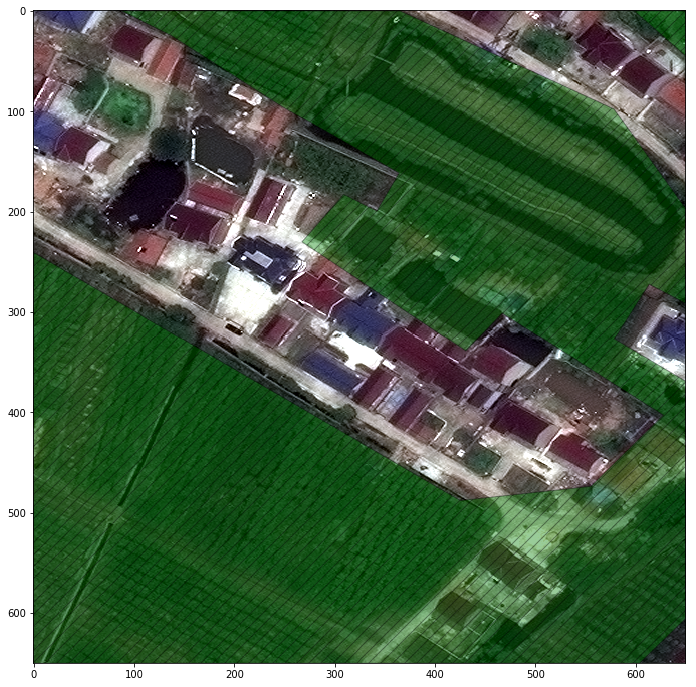

In [36]:
farmyard = landuse[landuse.landuse == 'farmyard'].unary_union
image_farmyard_area = farmyard.intersection(img_bounds)
image_farmyard_area_pxcoords = shapely.affinity.affine_transform(image_farmyard_area, img_transform)

# Subtract out the farmyards from the farmland coordinates
image_farmland_area_pxcoords = image_farmland_area_pxcoords - image_farmyard_area_pxcoords

fig, ax = plt.subplots(figsize=(12,12))

# Plot the image
ax.imshow(scale_bands(img))

# Plot the forest on top of the image
ax.add_patch(PolygonPatch(image_farmland_area_pxcoords, fc='g', alpha=0.4, hatch='//'))


Well that actually looks pretty good. Not perfect, though, so I did go ahead and start hand-marking a bunch of the images with QGIS.  All-in-all, though, this quick method turned out decent.  Below we show how to create a single ground truth mask of the above image.

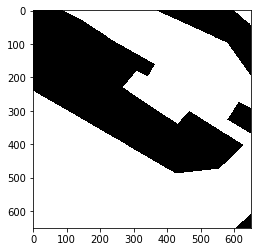

In [38]:
import cv2

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

# Convert the forest polygon into a mask
farmland_mask = make_mask(img.shape, image_farmland_area_pxcoords)

# Plot it
plt.imshow(farmland_mask, cmap=plt.cm.gray)

Perfect.

So this serves as the ground truth for the above image.  Feel free to browse the linked Github repository to see the full process of training the network on the entire dataset.